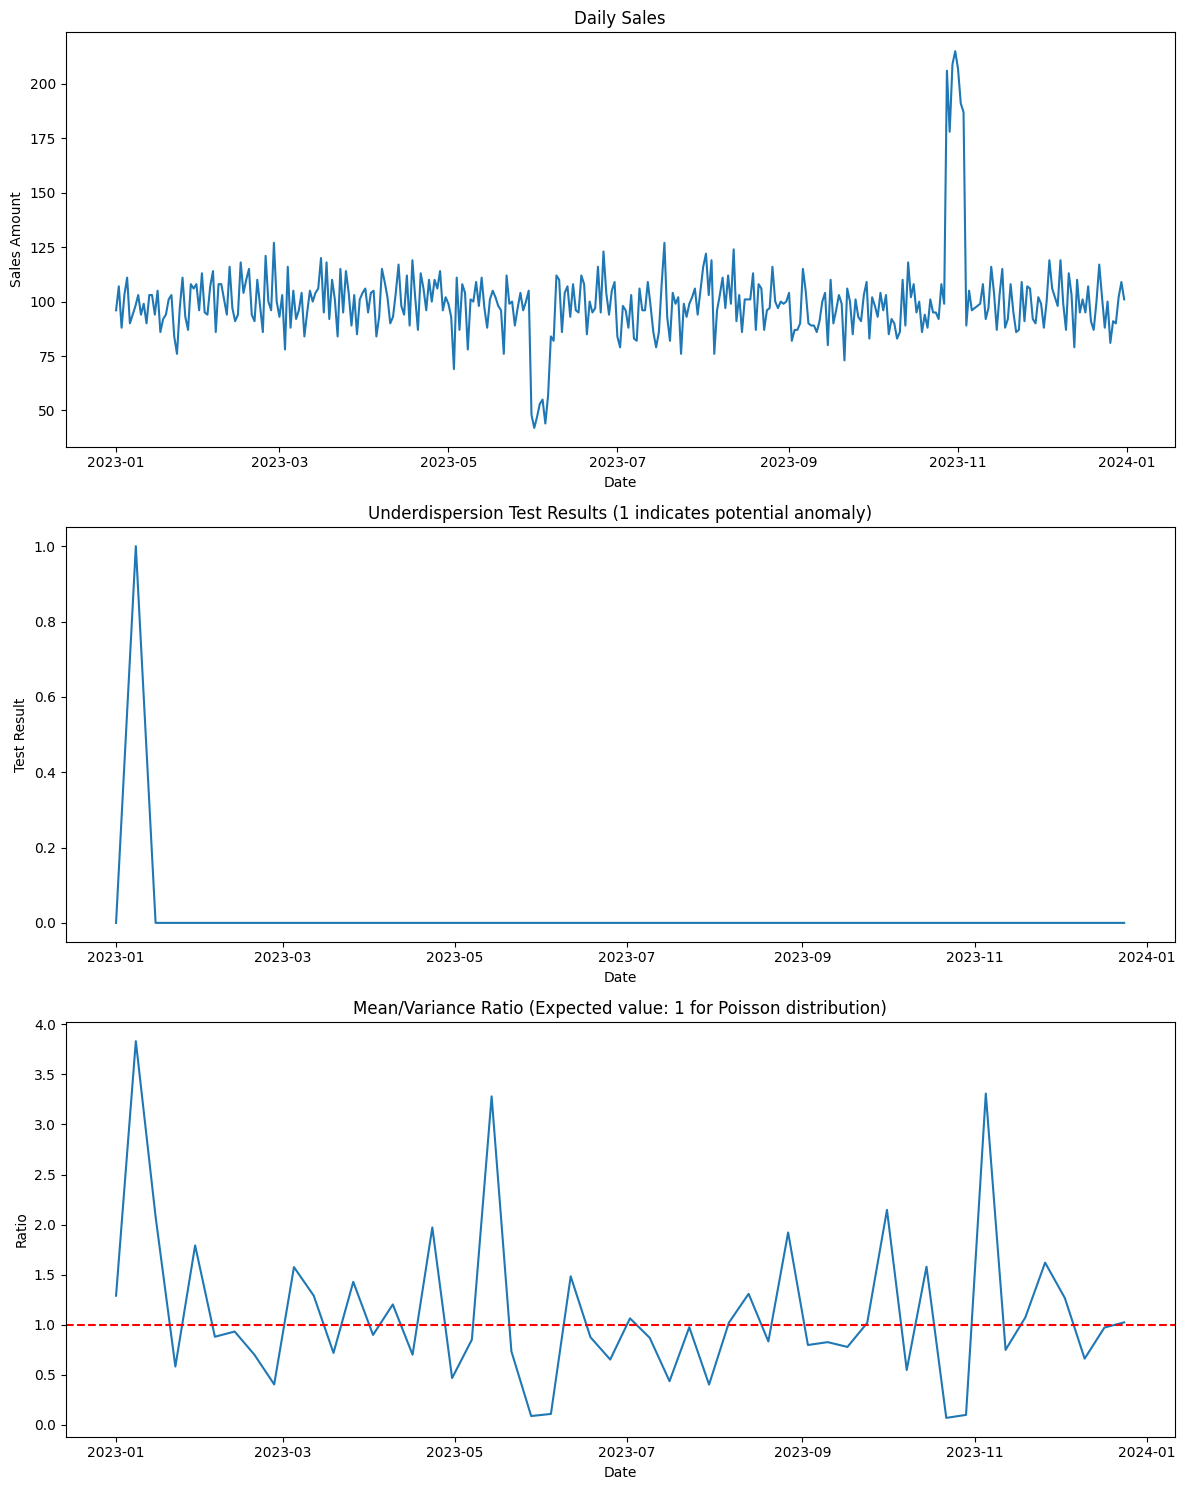

Total days analyzed: 365
Number of potential anomalies detected: 1.0
Percentage of weeks flagged as potential anomalies: 1.92%

Does the sales data meet the criterion for significant anomalies? No

Periods with potential anomalies:
Week starting: 2023-01-08


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson

def poisson_sample_var(mu, n, perc=5, nrep=1000, seed=42):
    np.random.seed(seed)
    v = np.zeros(nrep)
    for i in range(nrep):
        x = np.random.poisson(mu, size=n)
        v[i] = np.var(x, ddof=1)
    return np.percentile(v, perc)

def analyze_sales_data(sales_data, window=7, nrep=1000, perc=5, seed=42):
    length = len(sales_data) // window
    test_result = np.zeros(length)
    ratio = np.zeros(length)
    
    for i in range(length):
        window_data = sales_data[i*window:(i+1)*window]
        window_mean = np.mean(window_data)
        window_var = np.var(window_data, ddof=1)
        
        if window_var < poisson_sample_var(window_mean, window, nrep=nrep, perc=perc, seed=seed):
            test_result[i] = 1
        
        ratio[i] = window_mean / (window_var + 0.1)
    
    return test_result, ratio

def criterion(test_results, cutoff=3, chunk_cutoff=2):
    total_anomalies = np.sum(test_results)
    max_consecutive = len(max("".join(map(str, test_results.astype('int'))).split("0")))
    return total_anomalies >= cutoff or max_consecutive >= chunk_cutoff

def plot_sales_analysis(dates, sales, test_result, ratio):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))
    
    # Plot daily sales
    ax1.plot(dates, sales)
    ax1.set_title('Daily Sales')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Sales Amount')
    
    # Plot test results and ratio
    window_dates = dates[::7][:len(test_result)]  # Ensure we have the correct number of dates
    
    ax2.plot(window_dates, test_result)
    ax2.set_title('Underdispersion Test Results (1 indicates potential anomaly)')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Test Result')
    
    ax3.plot(window_dates, ratio)
    ax3.axhline(y=1, color='r', linestyle='--')
    ax3.set_title('Mean/Variance Ratio (Expected value: 1 for Poisson distribution)')
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Ratio')
    
    plt.tight_layout()
    plt.show()

# Example usage
np.random.seed(42)
dates = pd.date_range(start='2023-01-01', end='2023-12-31')
sales = np.random.poisson(lam=100, size=len(dates))

# Introduce some anomalies
sales[150:157] = np.random.poisson(lam=50, size=7)  # A week of lower sales
sales[300:307] = np.random.poisson(lam=200, size=7)  # A week of higher sales

test_result, ratio = analyze_sales_data(sales)
plot_sales_analysis(dates, sales, test_result, ratio)

# Print summary statistics
print(f"Total days analyzed: {len(sales)}")
print(f"Number of potential anomalies detected: {np.sum(test_result)}")
print(f"Percentage of weeks flagged as potential anomalies: {np.mean(test_result)*100:.2f}%")

# Apply criterion
meets_criterion = criterion(test_result)
print(f"\nDoes the sales data meet the criterion for significant anomalies? {'Yes' if meets_criterion else 'No'}")

# Identify specific periods with potential anomalies
window_dates = dates[::7][:len(test_result)]
anomaly_periods = [date for date, result in zip(window_dates, test_result) if result == 1]
print("\nPeriods with potential anomalies:")
for period in anomaly_periods:
    print(f"Week starting: {period.date()}")

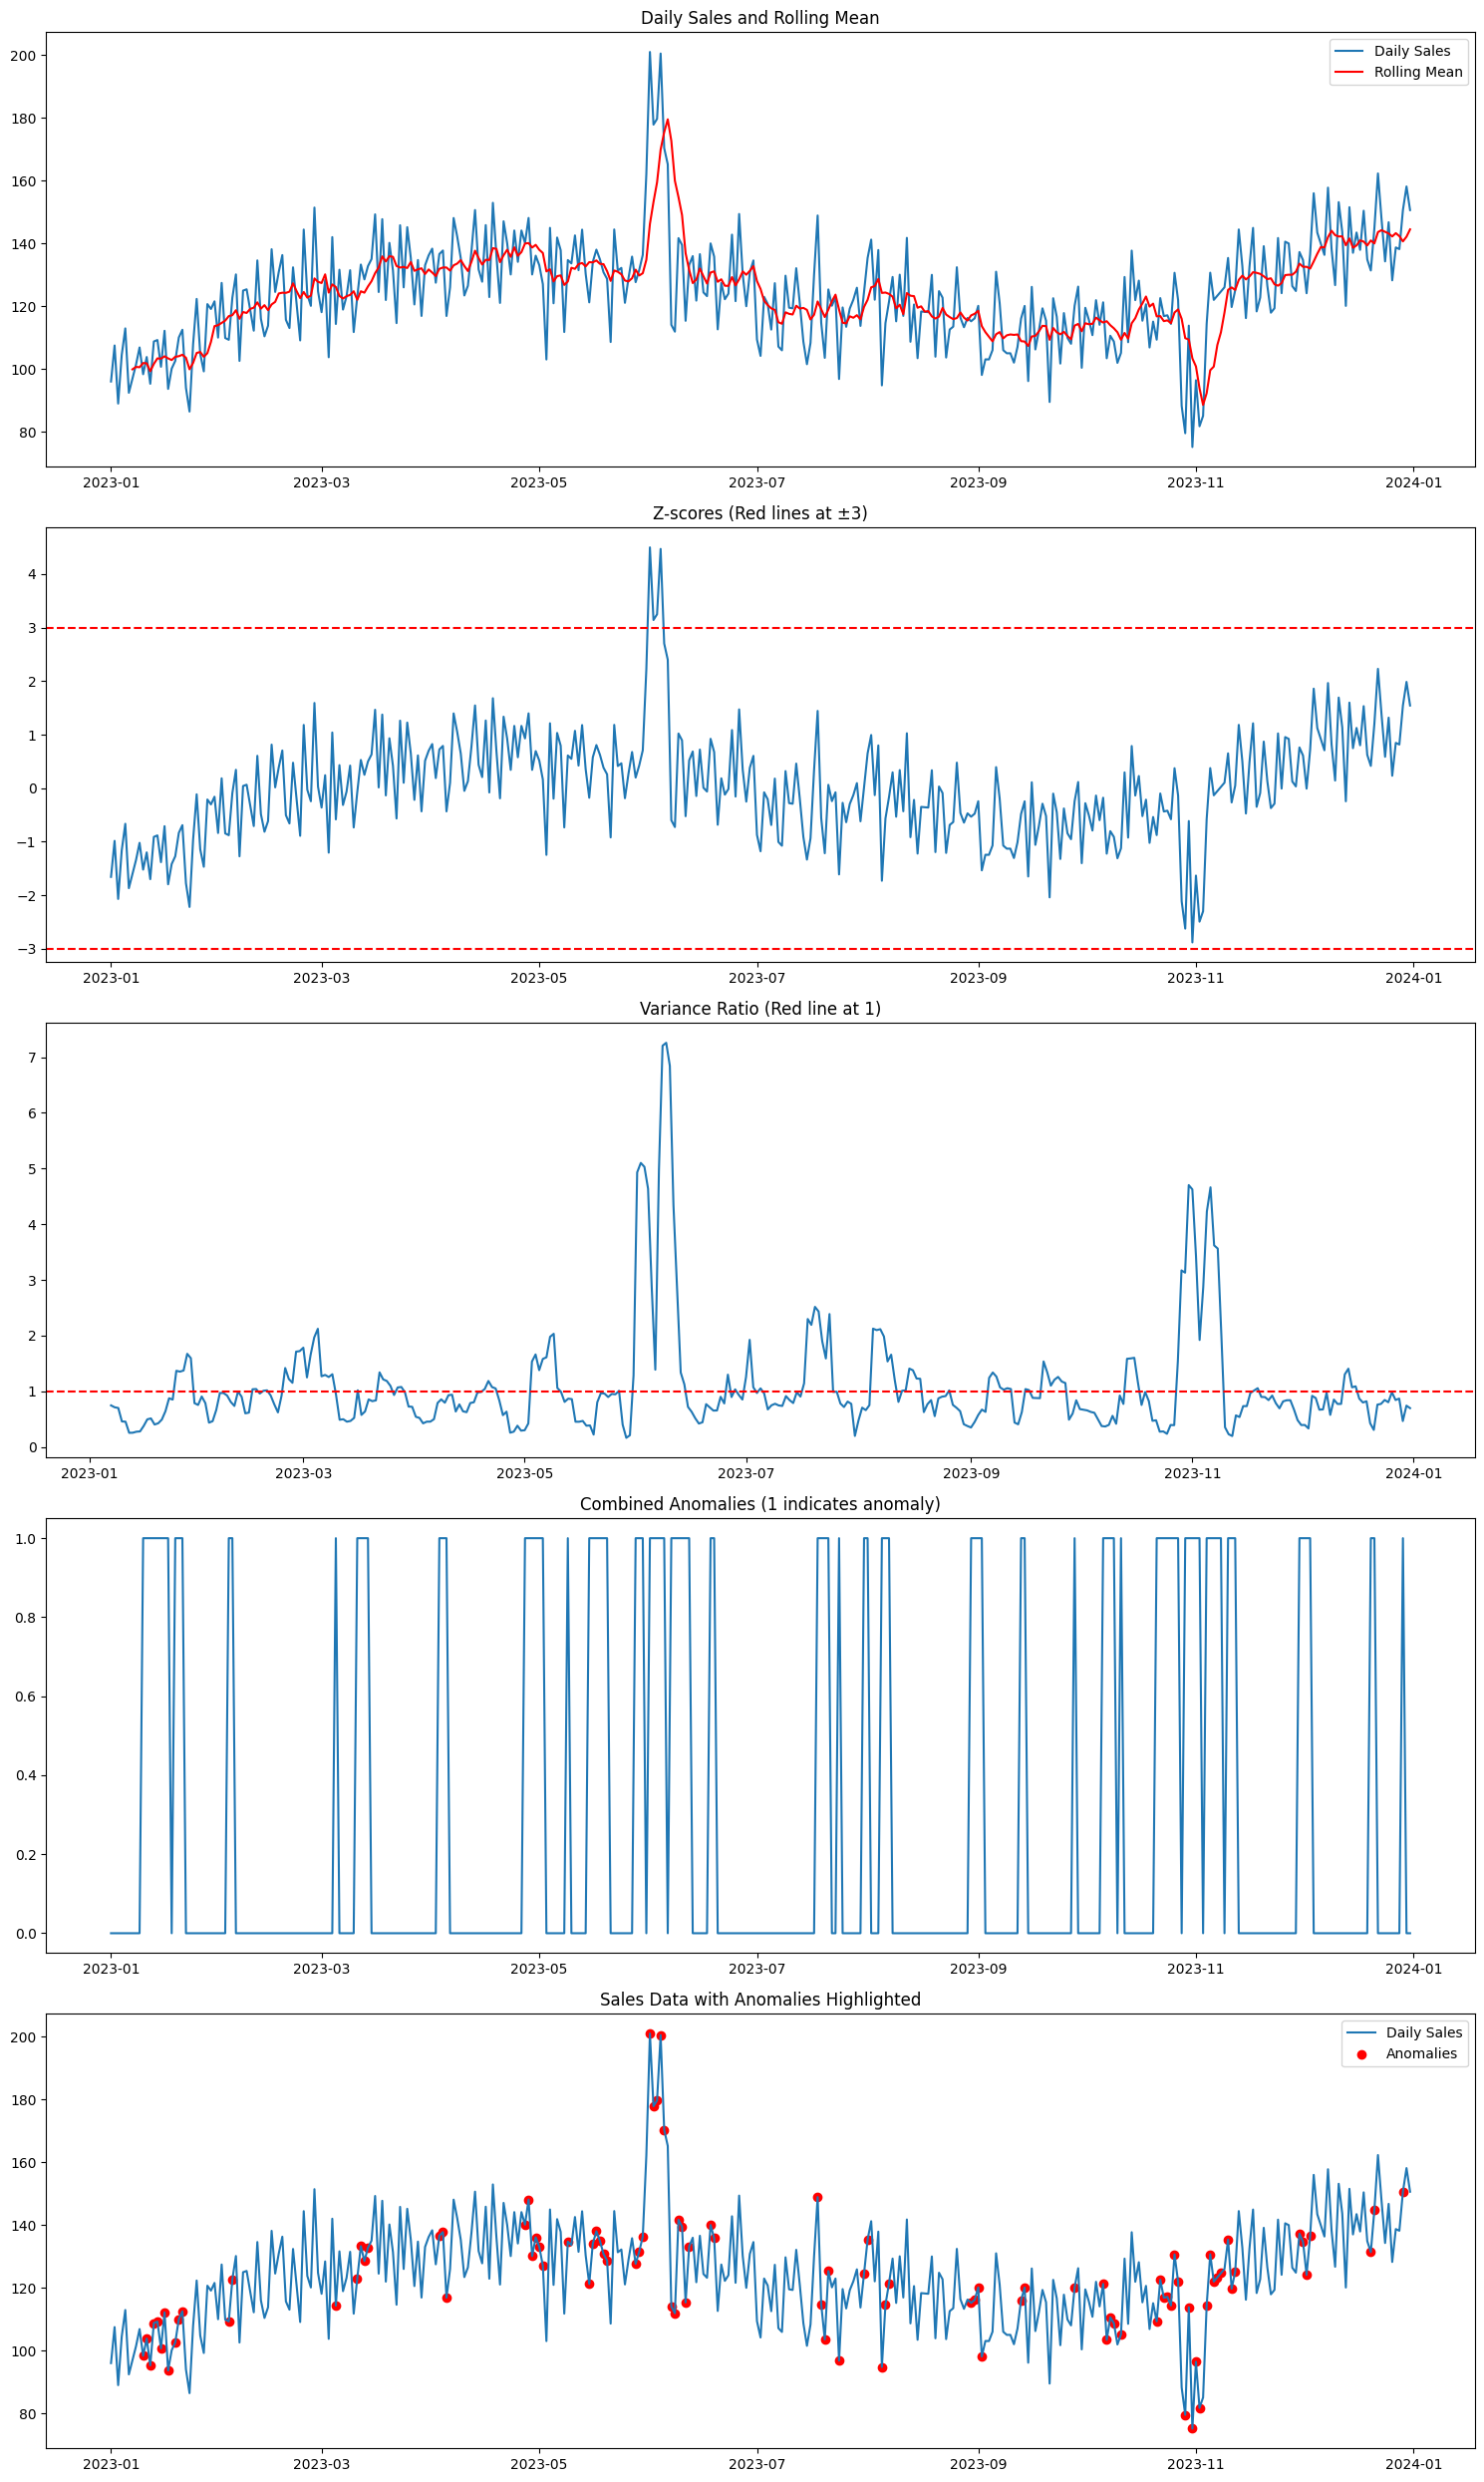

Total days analyzed: 365
Number of anomalies detected: 99
Percentage of days flagged as anomalies: 27.12%

Dates with detected anomalies:
Date: 2023-01-10, Sales: 98.32
Date: 2023-01-11, Sales: 103.80
Date: 2023-01-12, Sales: 95.28
Date: 2023-01-13, Sales: 108.75
Date: 2023-01-14, Sales: 109.22
Date: 2023-01-15, Sales: 100.70
Date: 2023-01-16, Sales: 112.17
Date: 2023-01-17, Sales: 93.64
Date: 2023-01-19, Sales: 102.57
Date: 2023-01-20, Sales: 110.04
Date: 2023-01-21, Sales: 112.50
Date: 2023-02-03, Sales: 109.29
Date: 2023-02-04, Sales: 122.72
Date: 2023-03-05, Sales: 114.34
Date: 2023-03-11, Sales: 123.03
Date: 2023-03-12, Sales: 133.29
Date: 2023-03-13, Sales: 128.55
Date: 2023-03-14, Sales: 132.80
Date: 2023-04-03, Sales: 136.64
Date: 2023-04-04, Sales: 137.77
Date: 2023-04-05, Sales: 116.89
Date: 2023-04-27, Sales: 140.15
Date: 2023-04-28, Sales: 148.14
Date: 2023-04-29, Sales: 130.13
Date: 2023-04-30, Sales: 136.11
Date: 2023-05-01, Sales: 133.08
Date: 2023-05-02, Sales: 127.06
D

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson, zscore
from statsmodels.tsa.seasonal import seasonal_decompose

def analyze_sales_data(sales_data, window=7):
    # Calculate rolling statistics
    rolling_mean = sales_data.rolling(window=window).mean()
    rolling_var = sales_data.rolling(window=window).var()
    
    # Calculate empirical Z-scores
    z_scores = zscore(sales_data)
    
    # Poisson comparison
    poisson_var = rolling_mean  # In Poisson distribution, mean = variance
    variance_ratio = rolling_var / poisson_var
    
    return rolling_mean, rolling_var, z_scores, variance_ratio

def detect_anomalies(sales_data, z_scores, variance_ratio, z_threshold=3, var_ratio_threshold=2):
    anomalies = pd.DataFrame(index=sales_data.index)
    
    # Z-score based anomalies
    anomalies['z_score_anomaly'] = (abs(z_scores) > z_threshold).astype(int)
    
    # Variance ratio based anomalies
    anomalies['var_ratio_anomaly'] = ((variance_ratio > var_ratio_threshold) | (variance_ratio < 1/var_ratio_threshold)).astype(int)
    
    # Combine anomalies
    anomalies['combined_anomaly'] = ((anomalies['z_score_anomaly'] == 1) | (anomalies['var_ratio_anomaly'] == 1)).astype(int)
    
    return anomalies

def plot_sales_analysis(sales_data, rolling_mean, rolling_var, z_scores, variance_ratio, anomalies):
    fig, axes = plt.subplots(5, 1, figsize=(15, 25))
    
    # Plot daily sales and rolling mean
    axes[0].plot(sales_data.index, sales_data, label='Daily Sales')
    axes[0].plot(rolling_mean.index, rolling_mean, label='Rolling Mean', color='red')
    axes[0].set_title('Daily Sales and Rolling Mean')
    axes[0].legend()
    
    # Plot Z-scores
    axes[1].plot(z_scores.index, z_scores)
    axes[1].axhline(y=3, color='r', linestyle='--')
    axes[1].axhline(y=-3, color='r', linestyle='--')
    axes[1].set_title('Z-scores (Red lines at ±3)')
    
    # Plot Variance Ratio
    axes[2].plot(variance_ratio.index, variance_ratio)
    axes[2].axhline(y=1, color='r', linestyle='--')
    axes[2].set_title('Variance Ratio (Red line at 1)')
    
    # Plot Combined Anomalies
    axes[3].plot(anomalies.index, anomalies['combined_anomaly'])
    axes[3].set_title('Combined Anomalies (1 indicates anomaly)')
    
    # Plot Sales with Anomalies Highlighted
    axes[4].plot(sales_data.index, sales_data, label='Daily Sales')
    anomaly_points = sales_data[anomalies['combined_anomaly'] == 1]
    axes[4].scatter(anomaly_points.index, anomaly_points, color='red', label='Anomalies')
    axes[4].set_title('Sales Data with Anomalies Highlighted')
    axes[4].legend()
    
    plt.tight_layout()
    plt.show()

# Example usage
np.random.seed(42)
dates = pd.date_range(start='2023-01-01', end='2023-12-31')
base_sales = np.random.poisson(lam=100, size=len(dates))

# Add seasonality and trend
seasonality = 20 * np.sin(np.arange(len(dates)) * (2 * np.pi / 365))
trend = np.linspace(0, 50, len(dates))
sales = base_sales + seasonality + trend

# Introduce some anomalies
sales[150:157] += 50  # A week of higher sales
sales[300:307] -= 30  # A week of lower sales

# Convert to pandas Series
sales_data = pd.Series(sales, index=dates)

# Analyze sales data
rolling_mean, rolling_var, z_scores, variance_ratio = analyze_sales_data(sales_data)

# Detect anomalies
anomalies = detect_anomalies(sales_data, z_scores, variance_ratio)

# Plot results
plot_sales_analysis(sales_data, rolling_mean, rolling_var, z_scores, variance_ratio, anomalies)

# Print summary statistics
print(f"Total days analyzed: {len(sales_data)}")
print(f"Number of anomalies detected: {anomalies['combined_anomaly'].sum()}")
print(f"Percentage of days flagged as anomalies: {anomalies['combined_anomaly'].mean()*100:.2f}%")

# Identify specific periods with anomalies
anomaly_dates = anomalies[anomalies['combined_anomaly'] == 1].index
print("\nDates with detected anomalies:")
for date in anomaly_dates:
    print(f"Date: {date.date()}, Sales: {sales_data[date]:.2f}")

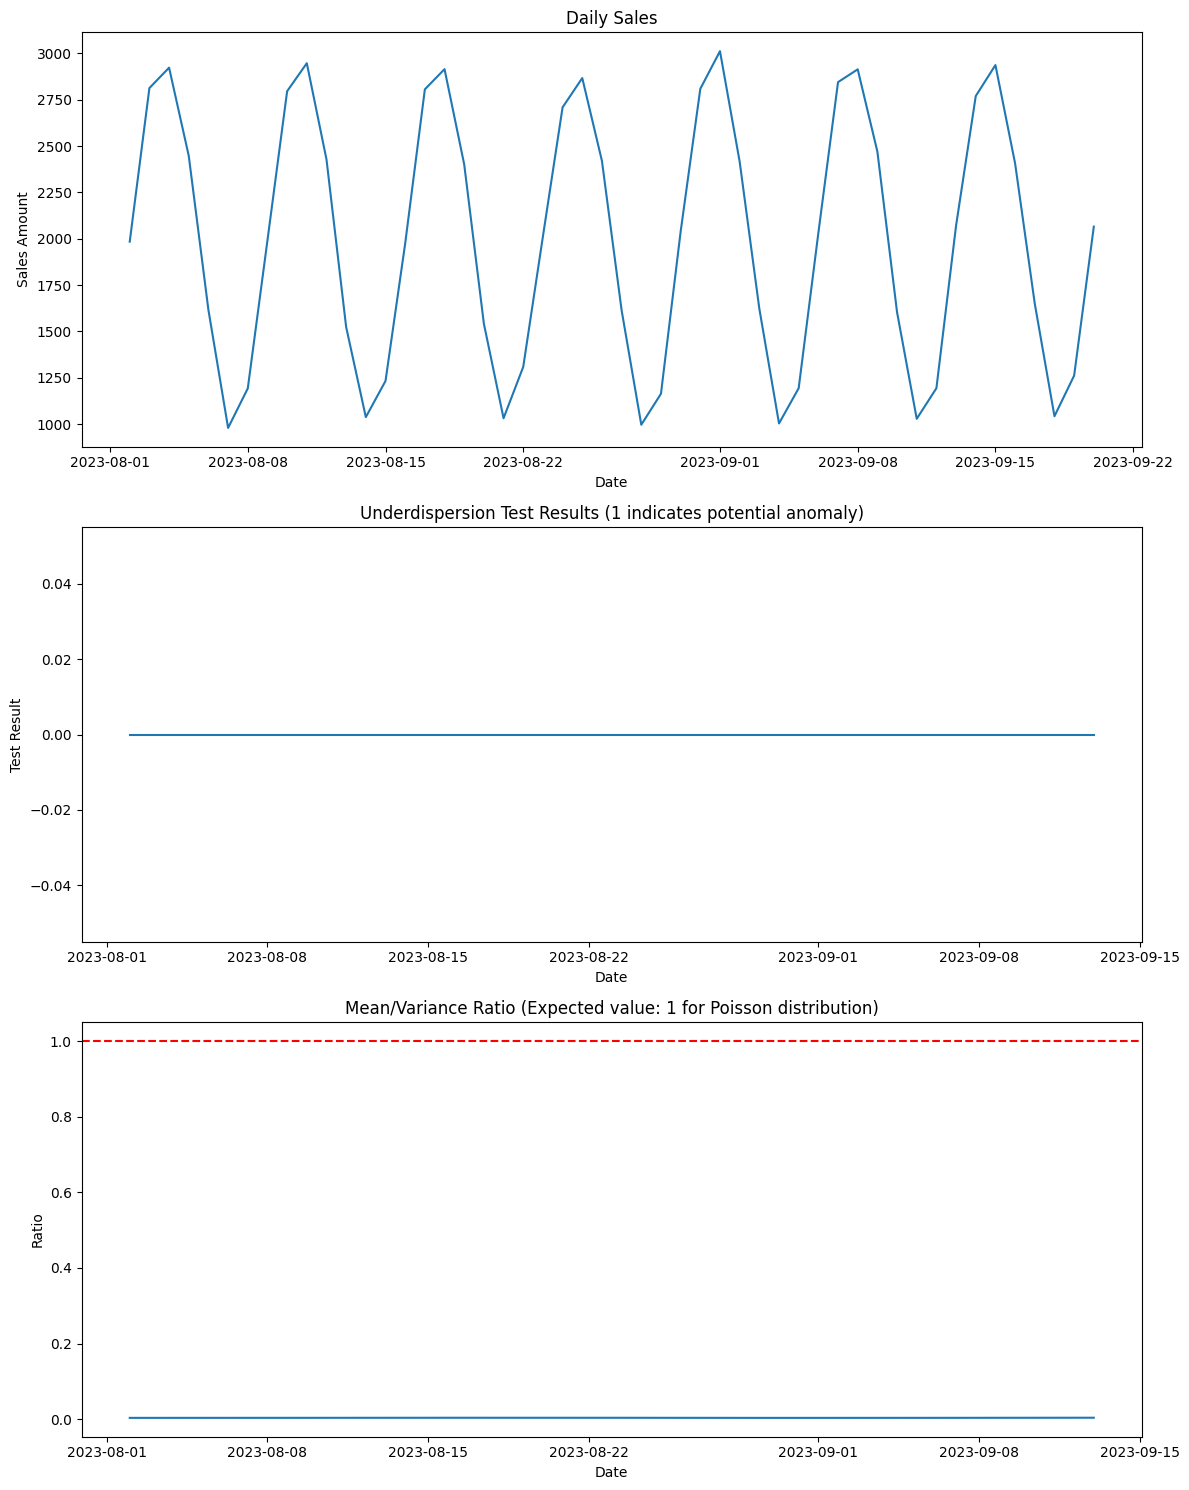

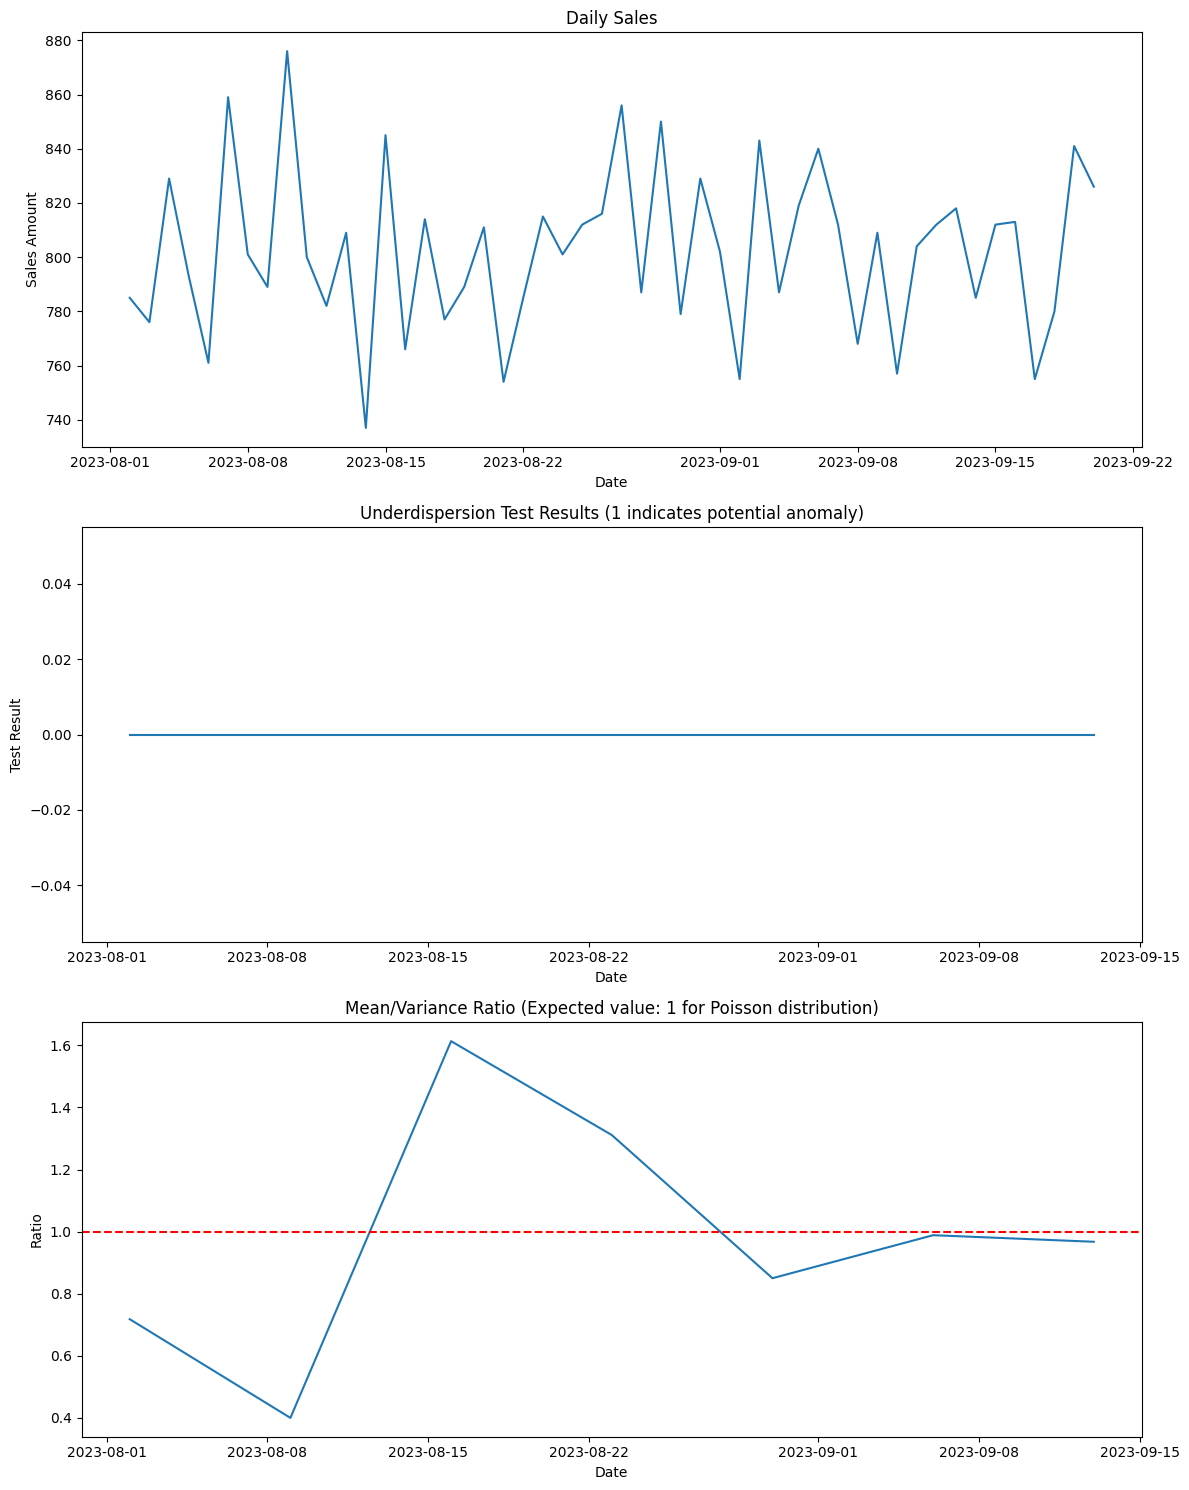

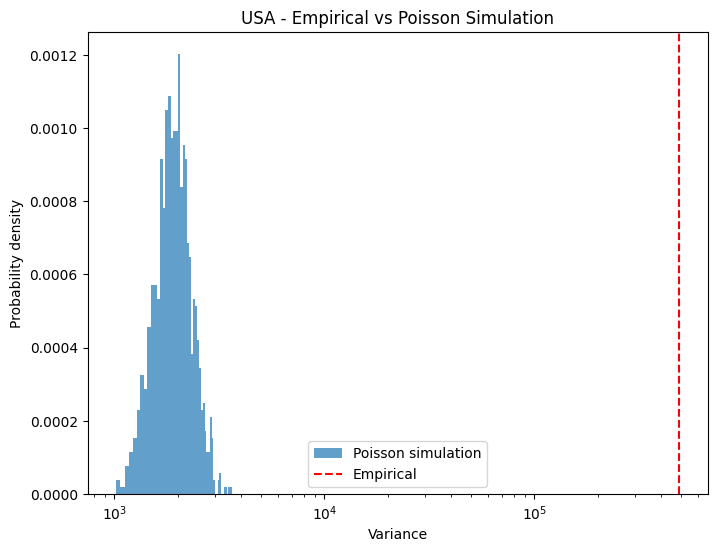

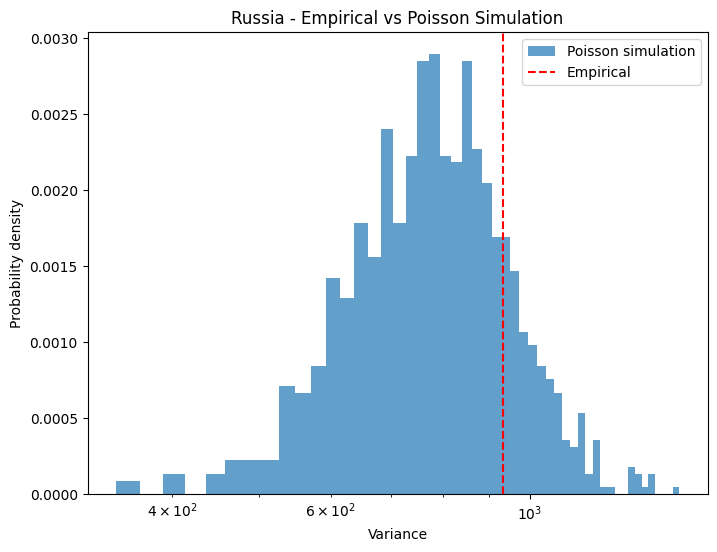

USA Analysis:
Mean sales: 2000.84
Variance: 489213.52
Underdispersion detected in 0.0 out of 7 weeks

Russia Analysis:
Mean sales: 802.42
Variance: 934.37
Underdispersion detected in 0.0 out of 7 weeks


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson

def poisson_sample_var(mu, n, perc=5, nrep=1000, seed=42):
    np.random.seed(seed)
    v = np.zeros(nrep)
    for i in range(nrep):
        x = np.random.poisson(mu, size=n)
        v[i] = np.var(x, ddof=1)
    return np.percentile(v, perc)

def analyze_sales_data(sales_data, window=7, nrep=1000, perc=5, seed=42):
    length = len(sales_data) // window
    test_result = np.zeros(length)
    ratio = np.zeros(length)
    
    for i in range(length):
        window_data = sales_data[i*window:(i+1)*window]
        window_mean = np.mean(window_data)
        window_var = np.var(window_data, ddof=1)
        
        if window_var < poisson_sample_var(window_mean, window, nrep=nrep, perc=perc, seed=seed):
            test_result[i] = 1
        
        ratio[i] = window_mean / (window_var + 0.1)
    
    return test_result, ratio

def plot_sales_analysis(dates, sales, test_result, ratio):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))
    
    # Plot daily sales
    ax1.plot(dates, sales)
    ax1.set_title('Daily Sales')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Sales Amount')
    
    # Plot test results and ratio
    window_dates = dates[::7][:len(test_result)]
    
    ax2.plot(window_dates, test_result)
    ax2.set_title('Underdispersion Test Results (1 indicates potential anomaly)')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Test Result')
    
    ax3.plot(window_dates, ratio)
    ax3.axhline(y=1, color='r', linestyle='--')
    ax3.set_title('Mean/Variance Ratio (Expected value: 1 for Poisson distribution)')
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Ratio')
    
    plt.tight_layout()
    plt.show()

def plot_variance_distribution(observed_var, simulated_vars, country):
    plt.figure(figsize=(8, 6))
    plt.hist(simulated_vars, bins=50, density=True, alpha=0.7, label='Poisson simulation')
    plt.axvline(observed_var, color='r', linestyle='--', label='Empirical')
    plt.xscale('log')
    plt.xlabel('Variance')
    plt.ylabel('Probability density')
    plt.title(f'{country} - Empirical vs Poisson Simulation')
    plt.legend()
    plt.show()

# Example usage
np.random.seed(42)
dates = pd.date_range(start='2023-08-02', end='2023-09-20')
sales_usa = np.random.poisson(lam=2000, size=len(dates)) + 1000 * np.sin(np.arange(len(dates)) * (2 * np.pi / 7))
sales_russia = np.random.poisson(lam=800, size=len(dates))

# Analyze sales data
test_result_usa, ratio_usa = analyze_sales_data(sales_usa)
test_result_russia, ratio_russia = analyze_sales_data(sales_russia)

# Plot sales analysis
plot_sales_analysis(dates, sales_usa, test_result_usa, ratio_usa)
plot_sales_analysis(dates, sales_russia, test_result_russia, ratio_russia)

# Generate variance distributions
observed_var_usa = np.var(sales_usa, ddof=1)
observed_var_russia = np.var(sales_russia, ddof=1)

simulated_vars_usa = [np.var(np.random.poisson(np.mean(sales_usa), size=len(sales_usa)), ddof=1) for _ in range(1000)]
simulated_vars_russia = [np.var(np.random.poisson(np.mean(sales_russia), size=len(sales_russia)), ddof=1) for _ in range(1000)]

# Plot variance distributions
plot_variance_distribution(observed_var_usa, simulated_vars_usa, 'USA')
plot_variance_distribution(observed_var_russia, simulated_vars_russia, 'Russia')

print("USA Analysis:")
print(f"Mean sales: {np.mean(sales_usa):.2f}")
print(f"Variance: {observed_var_usa:.2f}")
print(f"Underdispersion detected in {np.sum(test_result_usa)} out of {len(test_result_usa)} weeks")

print("\nRussia Analysis:")
print(f"Mean sales: {np.mean(sales_russia):.2f}")
print(f"Variance: {observed_var_russia:.2f}")
print(f"Underdispersion detected in {np.sum(test_result_russia)} out of {len(test_result_russia)} weeks")

In [35]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Set a seed for reproducibility
np.random.seed(42)

# Generate dates for a year
start_date = datetime(2023, 1, 1)
dates = [start_date + timedelta(days=i) for i in range(365)]

# Generate realistic sales data with trend and seasonality
t = np.arange(365)
trend = 100 + 0.5 * t
seasonality = 20 * np.sin(2 * np.pi * t / 365)
noise = np.random.normal(0, 10, 365)
sales = trend + seasonality + noise

# Ensure all sales are positive
sales = np.maximum(sales, 0)

# Create the DataFrame
real_df = pd.DataFrame({
    'ORDERDATE': dates,
    'SALES': np.round(sales, 2)
})

print(real_df.head())
print(f"Total rows: {len(real_df)}")

   ORDERDATE   SALES
0 2023-01-01  104.97
1 2023-01-02   99.46
2 2023-01-03  108.17
3 2023-01-04  117.76
4 2023-01-05  101.03
Total rows: 365


In [36]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Set a seed for reproducibility
np.random.seed(123)

# Generate dates for a year
start_date = datetime(2023, 1, 1)
dates = [start_date + timedelta(days=i) for i in range(365)]

# Generate completely random sales data
sales = np.random.uniform(50, 500, 365)

# Create the DataFrame
fake_df = pd.DataFrame({
    'ORDERDATE': dates,
    'SALES': np.round(sales, 2)
})

print(fake_df.head())
print(f"Total rows: {len(fake_df)}")

   ORDERDATE   SALES
0 2023-01-01  363.41
1 2023-01-02  178.76
2 2023-01-03  152.08
3 2023-01-04  298.09
4 2023-01-05  373.76
Total rows: 365


In [40]:
fake_df.to_csv('fake.csv', index=False)
real_df.to_csv('real.csv', index=False)




In [27]:
df = pd.read_csv("sample_sales\sales_data_sample.csv", encoding='Latin-1')
df.head()



ORDERNUMBER  QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  \
0        10107               30      95.70                2  2871.00   
1        10121               34      81.35                5  2765.90   
2        10134               41      94.74                2  3884.34   
3        10145               45      83.26                6  3746.70   
4        10159               49     100.00               14  5205.27   

         ORDERDATE   STATUS  QTR_ID  MONTH_ID  YEAR_ID  ...  \
0   2/24/2003 0:00  Shipped       1         2     2003  ...   
1    5/7/2003 0:00  Shipped       2         5     2003  ...   
2    7/1/2003 0:00  Shipped       3         7     2003  ...   
3   8/25/2003 0:00  Shipped       3         8     2003  ...   
4  10/10/2003 0:00  Shipped       4        10     2003  ...   

                    ADDRESSLINE1  ADDRESSLINE2           CITY STATE  \
0        897 Long Airport Avenue           NaN            NYC    NY   
1             59 rue de l'Abbaye           NaN          Reims   NaN   
2  27 rue du Colonel Pierre Avia           NaN          Paris   NaN   
3             78934 Hillside Dr.           NaN       Pasadena    CA   
4                7734 Strong St.           NaN  San Francisco    CA   

  POSTALCODE COUNTRY TERRITORY CONTACTLASTNAME CONTACTFIRSTNAME DEALSIZE  
0      10022     USA       NaN              Yu             Kwai    Small  
1      51100  France      EMEA         Henriot             Paul    Small  
2      75508  France      EMEA        Da Cunha           Daniel   Medium  
3      90003     USA       NaN           Young            Julie   Medium  
4        NaN     USA       NaN           Brown            Julie   Medium  

[5 rows x 25 columns]

In [28]:
df.value_counts("STATUS")

STATUS
Shipped       2617
Cancelled       60
Resolved        47
On Hold         44
In Process      41
Disputed        14
Name: count, dtype: int64

In [29]:
# df = df[df["STATUS"] == "Shipped"]
filtered_df = df[df["STATUS"] == "Shipped"]
filtered_df.head()


ORDERNUMBER  QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  \
0        10107               30      95.70                2  2871.00   
1        10121               34      81.35                5  2765.90   
2        10134               41      94.74                2  3884.34   
3        10145               45      83.26                6  3746.70   
4        10159               49     100.00               14  5205.27   

         ORDERDATE   STATUS  QTR_ID  MONTH_ID  YEAR_ID  ...  \
0   2/24/2003 0:00  Shipped       1         2     2003  ...   
1    5/7/2003 0:00  Shipped       2         5     2003  ...   
2    7/1/2003 0:00  Shipped       3         7     2003  ...   
3   8/25/2003 0:00  Shipped       3         8     2003  ...   
4  10/10/2003 0:00  Shipped       4        10     2003  ...   

                    ADDRESSLINE1  ADDRESSLINE2           CITY STATE  \
0        897 Long Airport Avenue           NaN            NYC    NY   
1             59 rue de l'Abbaye           NaN          Reims   NaN   
2  27 rue du Colonel Pierre Avia           NaN          Paris   NaN   
3             78934 Hillside Dr.           NaN       Pasadena    CA   
4                7734 Strong St.           NaN  San Francisco    CA   

  POSTALCODE COUNTRY TERRITORY CONTACTLASTNAME CONTACTFIRSTNAME DEALSIZE  
0      10022     USA       NaN              Yu             Kwai    Small  
1      51100  France      EMEA         Henriot             Paul    Small  
2      75508  France      EMEA        Da Cunha           Daniel   Medium  
3      90003     USA       NaN           Young            Julie   Medium  
4        NaN     USA       NaN           Brown            Julie   Medium  

[5 rows x 25 columns]

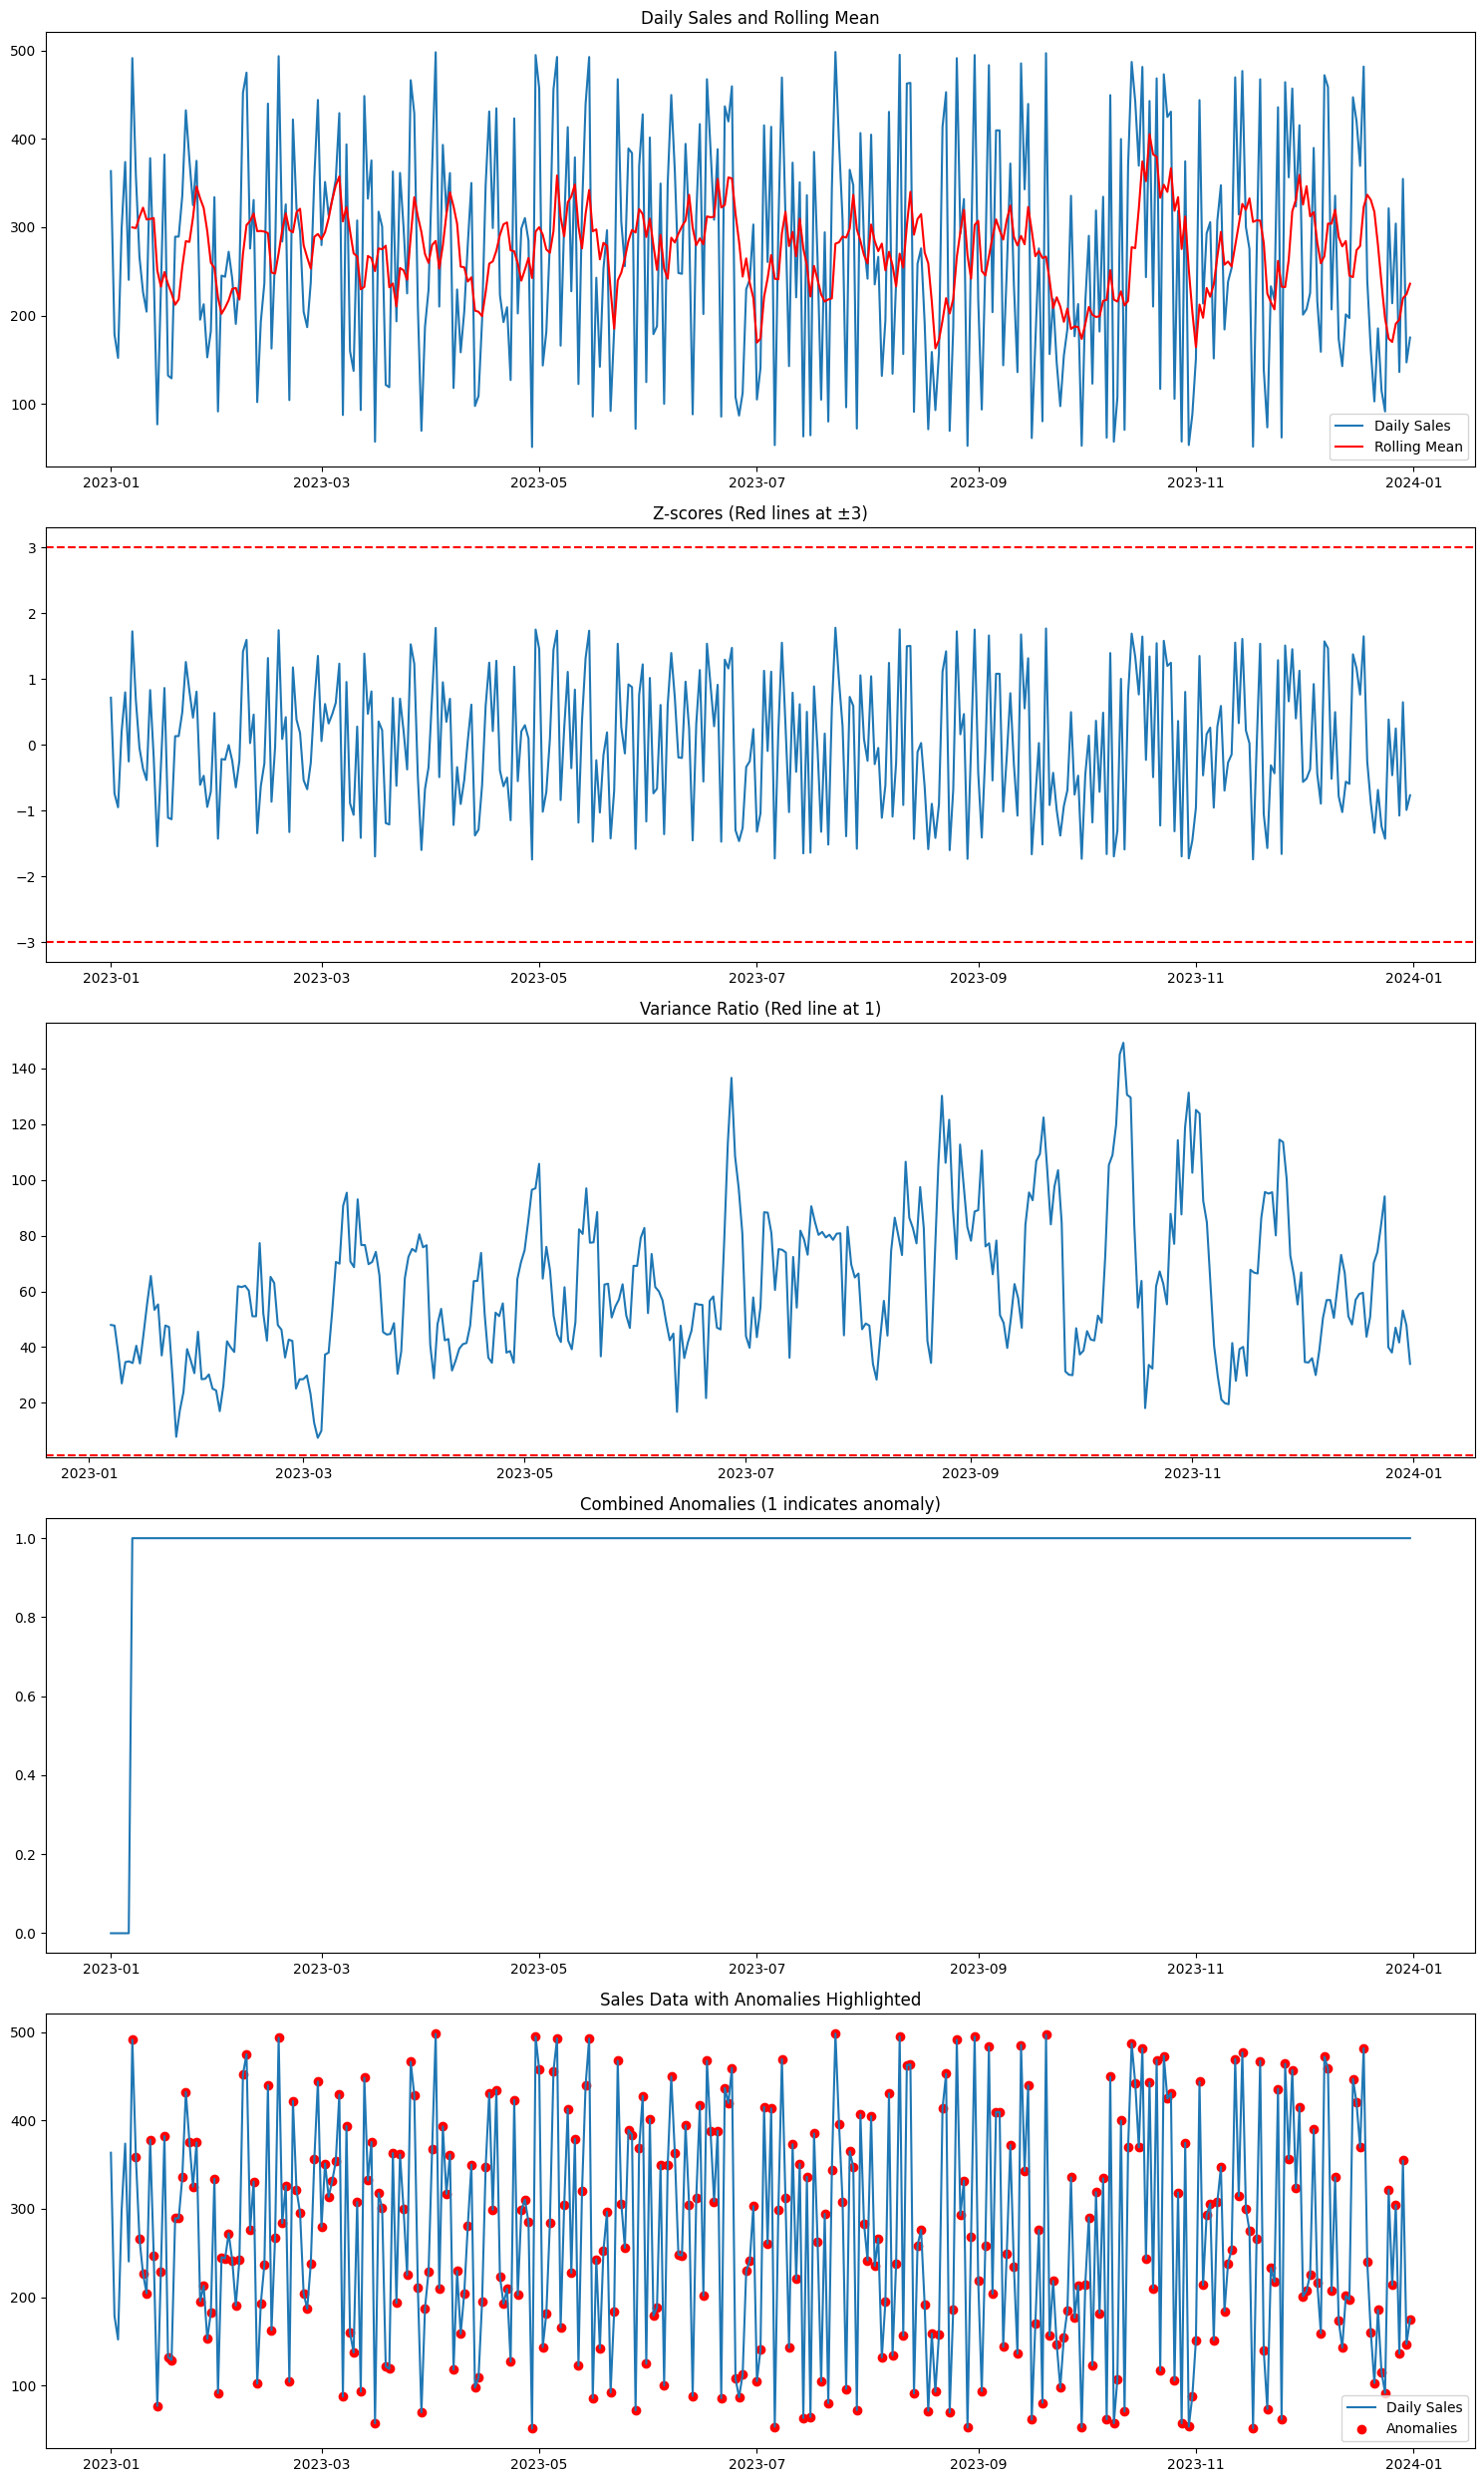

Total days analyzed: 365
Number of anomalies detected: 359
Percentage of days flagged as anomalies: 98.36%

Dates with detected anomalies:
Date: 2023-01-07, Sales: 491.34
Date: 2023-01-08, Sales: 358.17
Date: 2023-01-09, Sales: 266.42
Date: 2023-01-10, Sales: 226.45
Date: 2023-01-11, Sales: 204.43
Date: 2023-01-12, Sales: 378.07
Date: 2023-01-13, Sales: 247.36
Date: 2023-01-14, Sales: 76.86
Date: 2023-01-15, Sales: 229.12
Date: 2023-01-16, Sales: 382.10
Date: 2023-01-17, Sales: 132.12
Date: 2023-01-18, Sales: 128.95
Date: 2023-01-19, Sales: 289.20
Date: 2023-01-20, Sales: 289.32
Date: 2023-01-21, Sales: 335.48
Date: 2023-01-22, Sales: 432.24
Date: 2023-01-23, Sales: 376.00
Date: 2023-01-24, Sales: 324.96
Date: 2023-01-25, Sales: 375.10
Date: 2023-01-26, Sales: 195.33
Date: 2023-01-27, Sales: 212.80
Date: 2023-01-28, Sales: 152.72
Date: 2023-01-29, Sales: 182.17
Date: 2023-01-30, Sales: 333.94
Date: 2023-01-31, Sales: 91.45
Date: 2023-02-01, Sales: 245.17
Date: 2023-02-02, Sales: 243.89

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson, zscore
from statsmodels.tsa.seasonal import seasonal_decompose

def load_and_prepare_data(file_path):
    # Load the CSV file
    # df = pd.read_csv(file_path)
    df = fake_df
    
    # Convert ORDERDATE to datetime
    df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])
    
    # Sort by date and set it as index
    df = df.sort_values('ORDERDATE').set_index('ORDERDATE')
    
    # Resample to daily frequency, summing sales for each day
    daily_sales = df['SALES'].resample('D').sum()
    
    # Fill any missing days with 0 sales
    daily_sales = daily_sales.reindex(pd.date_range(start=daily_sales.index.min(), end=daily_sales.index.max()), fill_value=0)
    
    return daily_sales

def analyze_sales_data(sales_data, window=7):
    # Calculate rolling statistics
    rolling_mean = sales_data.rolling(window=window).mean()
    rolling_var = sales_data.rolling(window=window).var()
    
    # Calculate empirical Z-scores
    z_scores = zscore(sales_data)
    
    # Poisson comparison
    poisson_var = rolling_mean  # In Poisson distribution, mean = variance
    variance_ratio = rolling_var / poisson_var
    
    return rolling_mean, rolling_var, z_scores, variance_ratio

def detect_anomalies(sales_data, z_scores, variance_ratio, z_threshold=3, var_ratio_threshold=2):
    anomalies = pd.DataFrame(index=sales_data.index)
    
    # Z-score based anomalies
    anomalies['z_score_anomaly'] = (abs(z_scores) > z_threshold).astype(int)
    
    # Variance ratio based anomalies
    anomalies['var_ratio_anomaly'] = ((variance_ratio > var_ratio_threshold) | (variance_ratio < 1/var_ratio_threshold)).astype(int)
    
    # Combine anomalies
    anomalies['combined_anomaly'] = ((anomalies['z_score_anomaly'] == 1) | (anomalies['var_ratio_anomaly'] == 1)).astype(int)
    
    return anomalies

def plot_sales_analysis(sales_data, rolling_mean, rolling_var, z_scores, variance_ratio, anomalies):
    fig, axes = plt.subplots(5, 1, figsize=(15, 25))
    
    # Plot daily sales and rolling mean
    axes[0].plot(sales_data.index, sales_data, label='Daily Sales')
    axes[0].plot(rolling_mean.index, rolling_mean, label='Rolling Mean', color='red')
    axes[0].set_title('Daily Sales and Rolling Mean')
    axes[0].legend()
    
    # Plot Z-scores
    axes[1].plot(z_scores.index, z_scores)
    axes[1].axhline(y=3, color='r', linestyle='--')
    axes[1].axhline(y=-3, color='r', linestyle='--')
    axes[1].set_title('Z-scores (Red lines at ±3)')
    
    # Plot Variance Ratio
    axes[2].plot(variance_ratio.index, variance_ratio)
    axes[2].axhline(y=1, color='r', linestyle='--')
    axes[2].set_title('Variance Ratio (Red line at 1)')
    
    # Plot Combined Anomalies
    axes[3].plot(anomalies.index, anomalies['combined_anomaly'])
    axes[3].set_title('Combined Anomalies (1 indicates anomaly)')
    
    # Plot Sales with Anomalies Highlighted
    axes[4].plot(sales_data.index, sales_data, label='Daily Sales')
    anomaly_points = sales_data[anomalies['combined_anomaly'] == 1]
    axes[4].scatter(anomaly_points.index, anomaly_points, color='red', label='Anomalies')
    axes[4].set_title('Sales Data with Anomalies Highlighted')
    axes[4].legend()
    
    plt.tight_layout()
    plt.show()

# Main execution
file_path = 'your_sales_data.csv'  # Replace with your actual file path
sales_data = load_and_prepare_data(file_path)

# Analyze sales data
rolling_mean, rolling_var, z_scores, variance_ratio = analyze_sales_data(sales_data)

# Detect anomalies
anomalies = detect_anomalies(sales_data, z_scores, variance_ratio)

# Plot results
plot_sales_analysis(sales_data, rolling_mean, rolling_var, z_scores, variance_ratio, anomalies)

# Print summary statistics
print(f"Total days analyzed: {len(sales_data)}")
print(f"Number of anomalies detected: {anomalies['combined_anomaly'].sum()}")
print(f"Percentage of days flagged as anomalies: {anomalies['combined_anomaly'].mean()*100:.2f}%")

# Identify specific periods with anomalies
anomaly_dates = anomalies[anomalies['combined_anomaly'] == 1].index
print("\nDates with detected anomalies:")
for date in anomaly_dates:
    print(f"Date: {date.date()}, Sales: {sales_data[date]:.2f}")

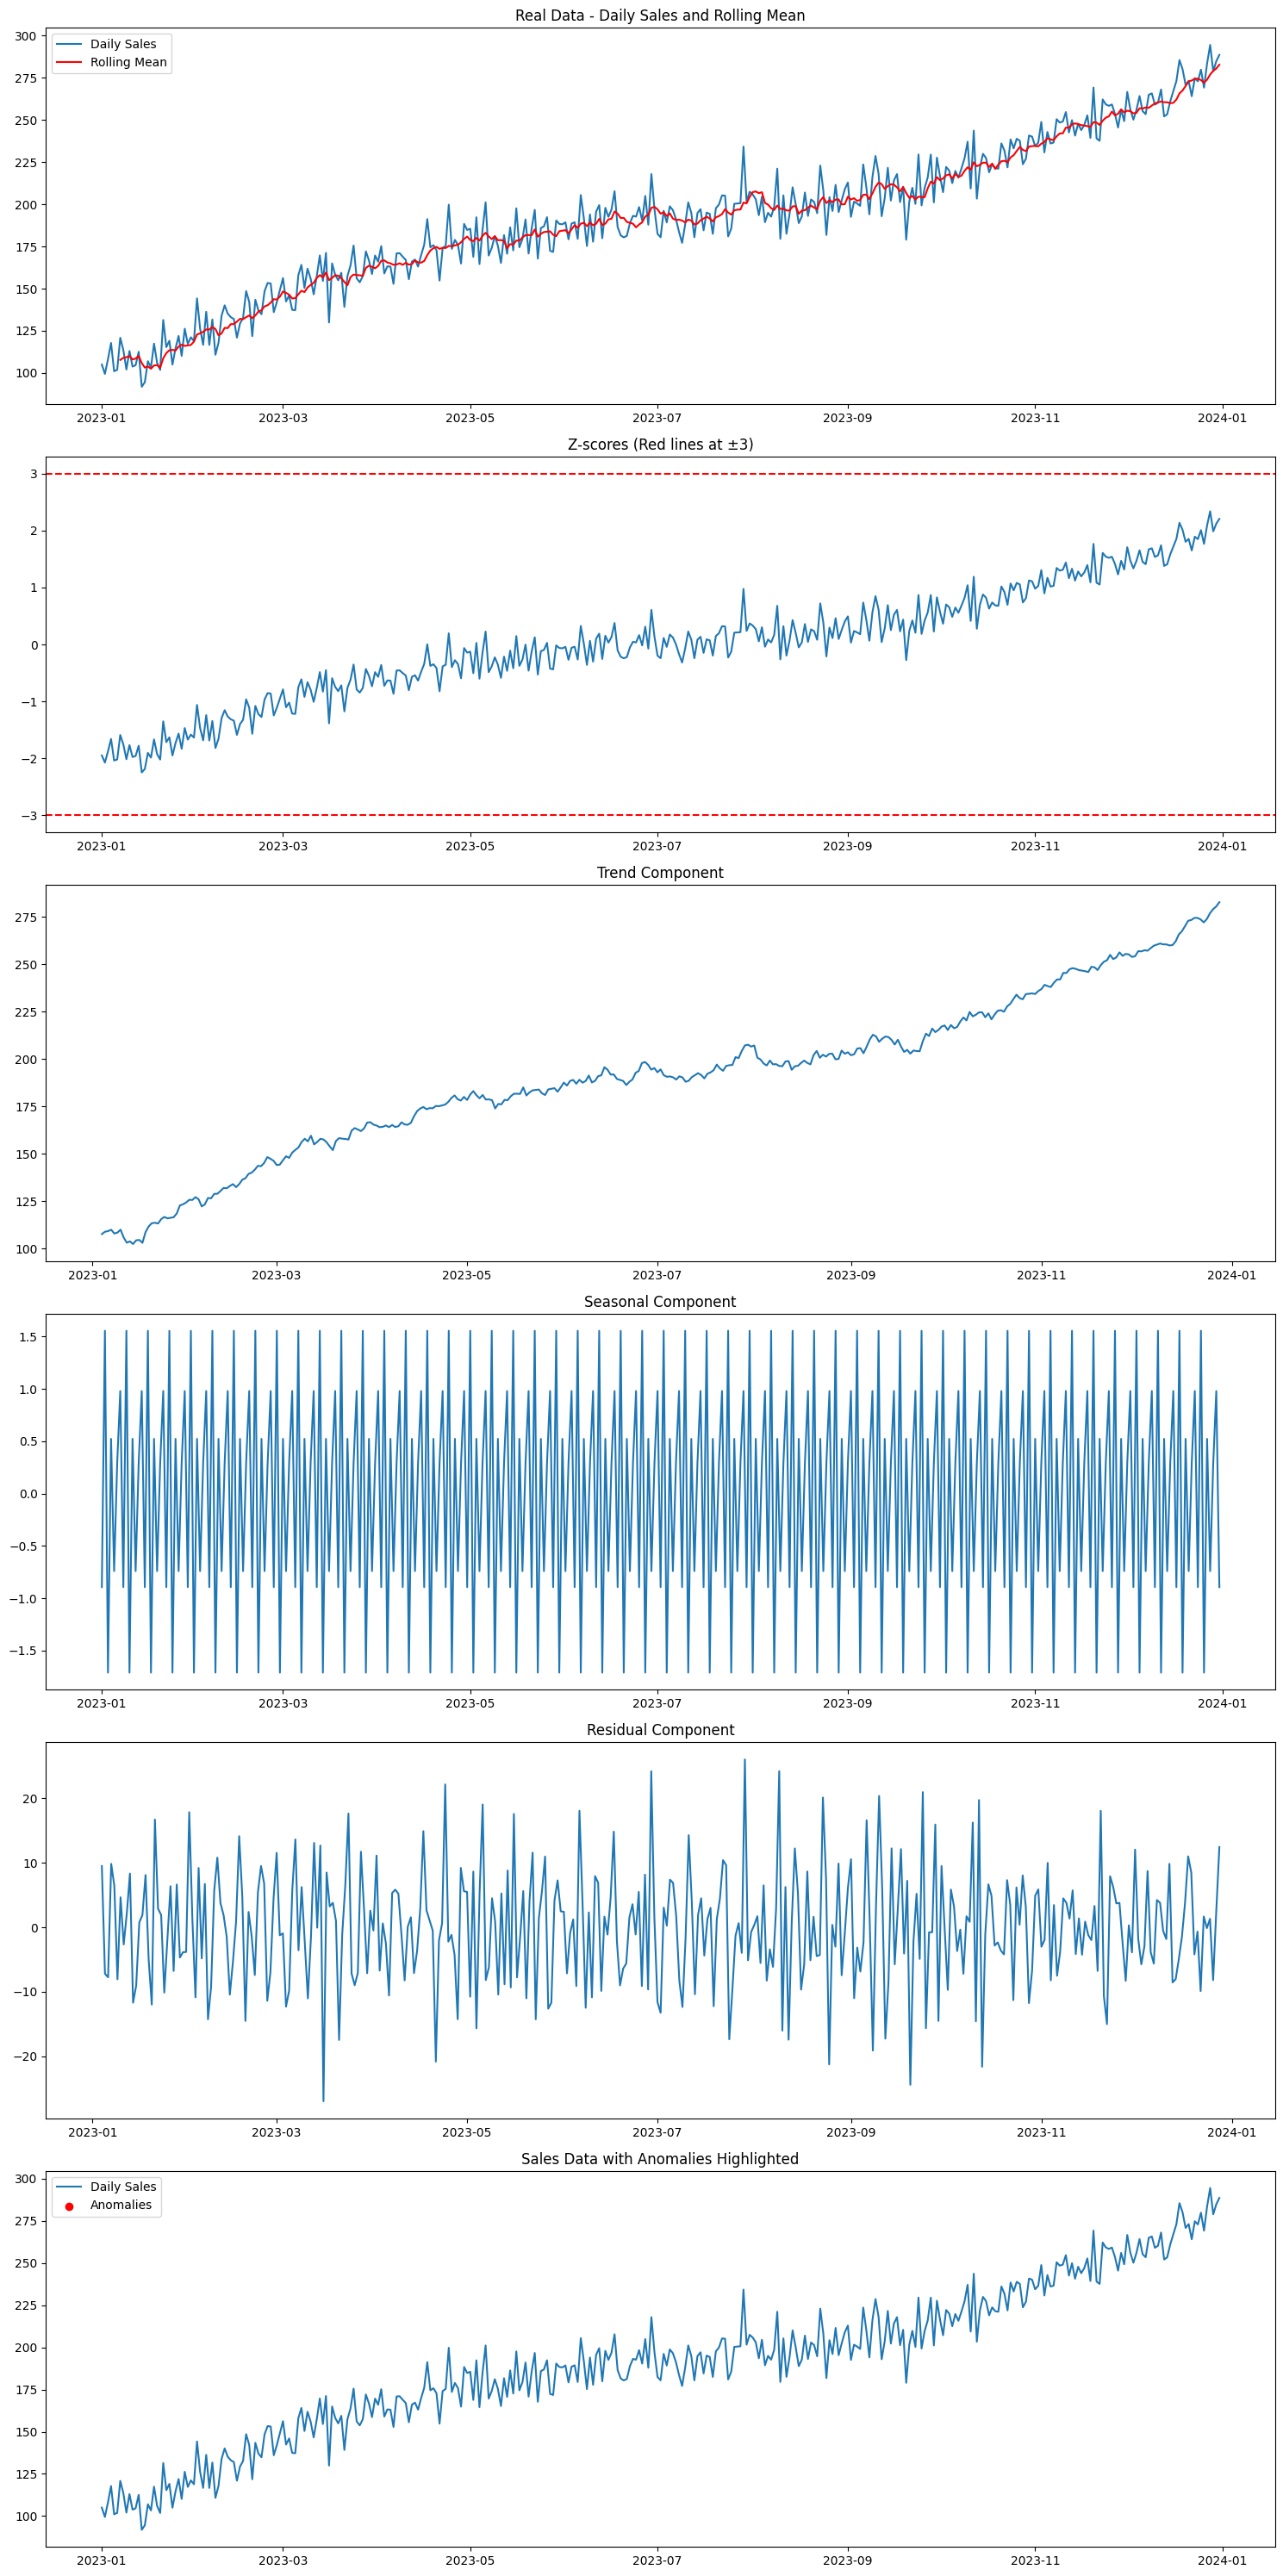


--- Real Data Analysis ---
Total days analyzed: 365
Number of anomalies detected: 0
Percentage of days flagged as anomalies: 0.00%


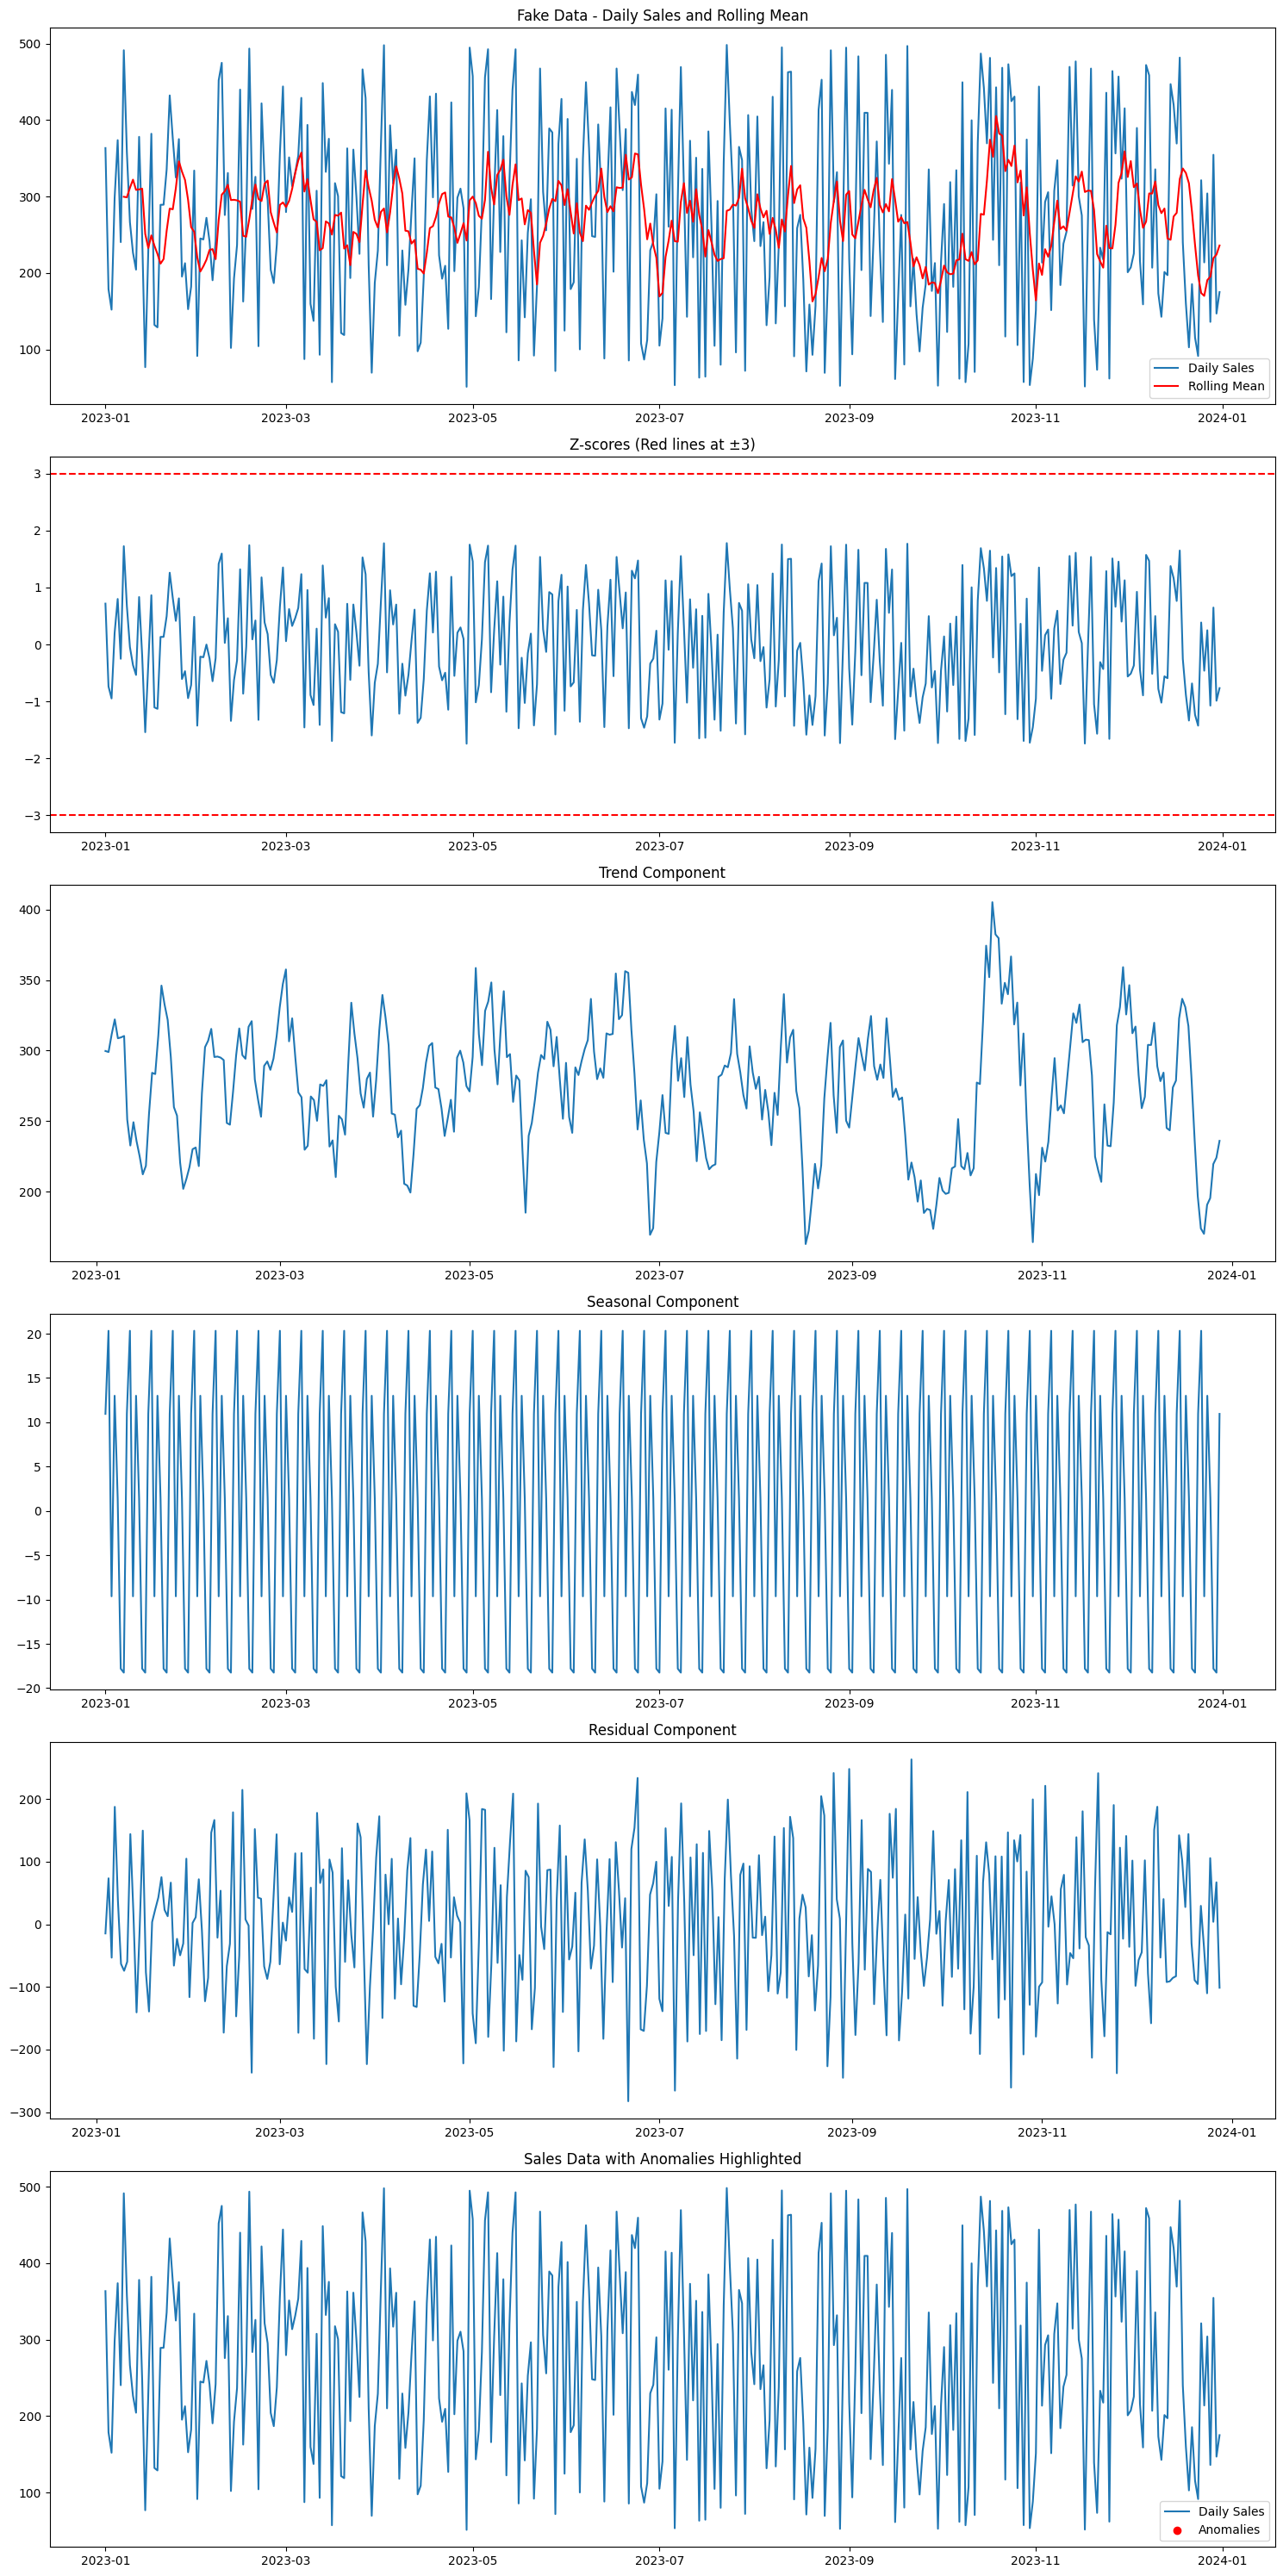


--- Fake Data Analysis ---
Total days analyzed: 365
Number of anomalies detected: 0
Percentage of days flagged as anomalies: 0.00%


In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore
from statsmodels.tsa.seasonal import seasonal_decompose

def load_and_prepare_data(file_path):
    df = pd.read_csv(file_path)
    df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])
    df = df.sort_values('ORDERDATE').set_index('ORDERDATE')
    daily_sales = df['SALES'].resample('D').sum()
    daily_sales = daily_sales.reindex(pd.date_range(start=daily_sales.index.min(), end=daily_sales.index.max()), fill_value=0)
    return daily_sales

def analyze_sales_data(sales_data, window=7):
    rolling_mean = sales_data.rolling(window=window).mean()
    rolling_std = sales_data.rolling(window=window).std()
    z_scores = zscore(sales_data)
    
    # Seasonal decomposition
    decomposition = seasonal_decompose(sales_data, model='additive', period=7)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    return rolling_mean, rolling_std, z_scores, trend, seasonal, residual

def detect_anomalies(sales_data, z_scores, rolling_mean, rolling_std, z_threshold=3, std_threshold=3):
    anomalies = pd.DataFrame(index=sales_data.index)
    
    # Z-score based anomalies
    anomalies['z_score_anomaly'] = (abs(z_scores) > z_threshold).astype(int)
    
    # Standard deviation based anomalies
    lower_bound = rolling_mean - (std_threshold * rolling_std)
    upper_bound = rolling_mean + (std_threshold * rolling_std)
    anomalies['std_anomaly'] = ((sales_data < lower_bound) | (sales_data > upper_bound)).astype(int)
    
    # Combine anomalies
    anomalies['combined_anomaly'] = ((anomalies['z_score_anomaly'] == 1) | (anomalies['std_anomaly'] == 1)).astype(int)
    
    return anomalies

def plot_sales_analysis(sales_data, rolling_mean, z_scores, trend, seasonal, residual, anomalies, title):
    fig, axes = plt.subplots(6, 1, figsize=(15, 30))
    
    axes[0].plot(sales_data.index, sales_data, label='Daily Sales')
    axes[0].plot(rolling_mean.index, rolling_mean, label='Rolling Mean', color='red')
    axes[0].set_title(f'{title} - Daily Sales and Rolling Mean')
    axes[0].legend()
    
    axes[1].plot(z_scores.index, z_scores)
    axes[1].axhline(y=3, color='r', linestyle='--')
    axes[1].axhline(y=-3, color='r', linestyle='--')
    axes[1].set_title('Z-scores (Red lines at ±3)')
    
    axes[2].plot(trend.index, trend)
    axes[2].set_title('Trend Component')
    
    axes[3].plot(seasonal.index, seasonal)
    axes[3].set_title('Seasonal Component')
    
    axes[4].plot(residual.index, residual)
    axes[4].set_title('Residual Component')
    
    axes[5].plot(sales_data.index, sales_data, label='Daily Sales')
    anomaly_points = sales_data[anomalies['combined_anomaly'] == 1]
    axes[5].scatter(anomaly_points.index, anomaly_points, color='red', label='Anomalies')
    axes[5].set_title('Sales Data with Anomalies Highlighted')
    axes[5].legend()
    
    plt.tight_layout()
    plt.show()

def analyze_dataset(file_path, title):
    sales_data = load_and_prepare_data(file_path)
    rolling_mean, rolling_std, z_scores, trend, seasonal, residual = analyze_sales_data(sales_data)
    anomalies = detect_anomalies(sales_data, z_scores, rolling_mean, rolling_std)
    plot_sales_analysis(sales_data, rolling_mean, z_scores, trend, seasonal, residual, anomalies, title)
    
    print(f"\n--- {title} Analysis ---")
    print(f"Total days analyzed: {len(sales_data)}")
    print(f"Number of anomalies detected: {anomalies['combined_anomaly'].sum()}")
    print(f"Percentage of days flagged as anomalies: {anomalies['combined_anomaly'].mean()*100:.2f}%")

# Main execution
real_data_path = 'real.csv'
fake_data_path = 'fake.csv'

analyze_dataset(real_data_path, "Real Data")
analyze_dataset(fake_data_path, "Fake Data")